In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf

In [3]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

postgres://andylane@localhost/restaurants


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sqlalchemy/dialects/__init__.py:34: SADeprecationWarning: The SQLAlchemy PostgreSQL dialect has been renamed from 'postgres' to 'postgresql'. The new URL format is postgresql[+driver]://<user>:<pass>@<host>/<dbname>
  module = __import__('sqlalchemy.dialects.%s' % (dialect, )).dialects


In [4]:
from menusights_aux import *

In [5]:
recipes = pd.read_sql("recipes", engine)

## Get recipe names into a vector

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [13]:
recipes.head()

,id,name,url,calories,fat,carbs,protein,cholesterol,sodium,servings
0,1,Fluffy Pancakes,http://allrecipes.com/recipe/162760/fluffy-pan...,230,8.2,32.7,6.4,65.0,650.0,4
1,2,Joan's Quick Chili,http://allrecipes.com/recipe/240622/joans-quic...,397,21.5,25.2,26.7,71.0,1438.0,4
2,3,Ultimate Double Chocolate Cookies,http://allrecipes.com/recipe/15097/ultimate-do...,148,6.8,21.4,2.2,25.0,88.0,42
3,4,Campfire Banana Splits,http://allrecipes.com/recipe/20038/campfire-ba...,545,17.3,106.2,4.7,0.0,47.0,6
4,5,Pumpkin Chocolate Chip Cookies II,http://allrecipes.com/recipe/10117/pumpkin-cho...,224,11.5,29.5,2.8,10.0,127.0,18


In [8]:
def clean_up_ingredient(ingredient_line):
    ingredient_line = re.sub("\[u\'", "", ingredient_line)
    ingredient_line = re.sub("\']", "", ingredient_line)
    return find_measurement_words(ingredient_line)

In [24]:
names = session.query(Recipe)

In [50]:
def get_ingredientslist_for_recipeid(i):
    return [clean_up_ingredient(item.ingredient)\
            for item in names.filter(Recipe.id == i).all()[0].ingredients]

In [54]:
b = get_ingredientslist_for_recipeid(1)

In [53]:
def make_ingredient_list_string(ingredientdictlist):
    return " ".join((j["ingredient"] for j in ingredientdictlist))

In [55]:
make_ingredient_list_string(b)

u'milk white vinegar all-purpose flour white sugar baking powder baking soda salt egg butter, melted spray'

In [58]:
def tokenize_and_stem(title, is_ingredient = False):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for word in nltk.word_tokenize(title):
        new_title.append(stemmer.stem(word))
    stemmed_titles.extend(new_title)
    return " ".join([i for i in stemmed_titles])

In [73]:
tokenized_ingredients = [tokenize_and_stem(make_ingredient_list_string(get_ingredientslist_for_recipeid(i))) for i in (recipes["id"])]

In [74]:
tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]

In [75]:
tokenized_names[99], 

(u'award win soft chocol chip cooki',)

In [76]:
tokenized_ingredients[99]

u'all-purpos flour bake soda butter , soften pack brown sugar white sugar ( 3.4 ounc ) packag instant vanilla pud mix egg vanilla extract semisweet chocol chip chop walnut ( option )'

In [77]:
tokenized_name_ing = zip(tokenized_names, tokenized_ingredients)

In [84]:
tokenized_name_ing = map(lambda a: " ".join(a), tokenized_name_ing)

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

In [86]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)

In [88]:
a = vectorizer.fit_transform(tokenized_name_ing)

In [89]:
len(vectorizer.get_feature_names())

27066

In [90]:
a

<3941x27066 sparse matrix of type '<type 'numpy.int64'>'
	with 305606 stored elements in Compressed Sparse Row format>

In [91]:
vectorizer.vocabulary_.get('minc')

13760

In [92]:
vectorizer.get_feature_names()[2256]

u'box barilla xa'

In [ ]:
sum(a.toarray()[:,2701])

In [93]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [94]:
# produces an array with mutual information (weights?) between individual words/n-grams in recipe names and cholesterol information
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [95]:
len(mi)

27066

In [ ]:
#[(index, i, vectorizer.get_feature_names()[index]) for index, i in enumerate(mi) if i>0.01]

In [194]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.03])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

In [195]:
len(informative_words)

1386

In [196]:
culled_array.shape

(3941, 1386)

In [197]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets, linear_model


X_train = culled_array
y_train = recipes["cholesterol"]

X_test = a[:200]
y_test = recipes["cholesterol"][:200]

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
# Try fitting an elasticnet model!
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
enet = ElasticNet()
enetmodel=enet.fit(culled_array[200:], y_train[200:])
y_predicted = enetmodel.predict(culled_array[:200])
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_enet = r2_score(y_test, y_predicted)
r2_score_enet #oh no it's -0.29...

-0.057371359158836954

In [199]:
import cPickle as pkl

In [200]:
ground_truth_x =[]
ground_truth_y =[]
for item in pkl.load(open("groundtruth.pkl", "rb")):
    try:
        if len(item["item_description"]) > 10:
            ground_truth_x.append(" ".join((item["item_name"], item["item_description"])))
            ground_truth_y.append(item["nf_cholesterol"])
    except:
        None

In [201]:
for item in pkl.load(open("groundtruth2.pkl", "rb")):
    try:
        if len(item["item_description"]) > 10:
            ground_truth_x.append(" ".join((item["item_name"], item["item_description"])))
            ground_truth_y.append(item["nf_cholesterol"])
    except:
        None

In [217]:
for item in pkl.load(open("groundtruth3.pkl", "rb")):
    try:
        if len(item["item_description"]) > 10:
            ground_truth_x.append(" ".join((item["item_name"], item["item_description"])))
            ground_truth_y.append(item["nf_cholesterol"])
    except:
        None

In [218]:
len(ground_truth_x)

316

In [219]:
ground_truth_x[0]

u'Outback Sirloin, 9 Oz SIGNATURE STEAKS - Outback Special 9 oz'

In [220]:
# tokenized_names_ground_truth = [tokenize_and_stem(i) for i in (ground_truth_x)]
# Include descriptions
tokenized_names_ground_truth = [tokenize_and_stem(i) for i in (ground_truth_x)]

In [221]:
# Puts words from new ground truth set into matrix from training set
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)

In [223]:
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
y_predicted = enetmodel.predict(ground_truth_vectorized_culled_array)
# r2_score_enet = r2_score(ground_truth_y, y_predicted)
# r2_score_enet #oh no it's still bad...

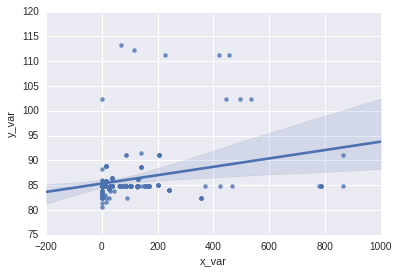

In [207]:
x,y = pd.Series(ground_truth_y, name="x_var"), pd.Series(y_predicted, name="y_var")
ax = sns.regplot(x=x, y=y)

## So, the elasticnet model (a linear regression) has poor predictive power at default parameters. Can we optimize the parameters?

In [208]:
%matplotlib inline
# Compute paths
from sklearn.linear_model import ElasticNetCV
import time, copy
from sklearn.metrics import r2_score
import seaborn as sns
def enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y):
    #culledarrayecv = np.sqrt(np.sum(culledarrayecv ** 2, axis=0)) / culledarrayecv
    model = ElasticNetCV(cv=20)
    out = model.fit(culled_array, y_train)
    #m_log_alphas = -np.log10(out.alphas_)
    #y_predicted_cv = out.predict(ground_truth_vectorized_culled_array)
    #x,y = pd.Series(ground_truth_y, name="actual cholesterol"), pd.Series(y_predicted_cv, name="predicted cholesterol")
    #ax = sns.regplot(x=x, y=y)
    return(out, model)

In [209]:
fit_enet = enetcv(culled_array, y_train, ground_truth_vectorized, ground_truth_y)

In [224]:
y_predicted_cv = fit_enet[0].predict(ground_truth_vectorized_culled_array)

In [225]:
culled_array.shape

(3941, 1386)

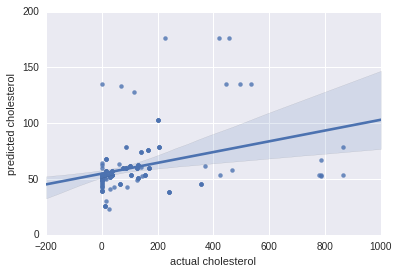

In [165]:
# Mutualinformation > 0.01
x,y = pd.Series(ground_truth_y, name="actual cholesterol"), pd.Series(y_predicted_cv, name="predicted cholesterol")
ax = sns.regplot(x=x, y=y)

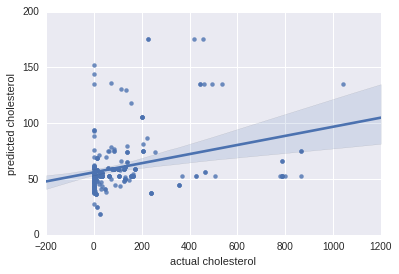

In [226]:
# Mutualinformation > 0.03
x,y = pd.Series(ground_truth_y, name="actual cholesterol"), pd.Series(y_predicted_cv, name="predicted cholesterol")
ax = sns.regplot(x=x, y=y)

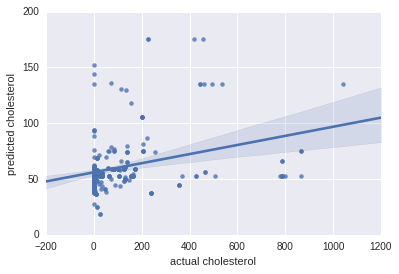

In [227]:
# Mutualinformation > 0.01
x,y = pd.Series(ground_truth_y, name="actual cholesterol"), pd.Series(y_predicted_cv, name="predicted cholesterol")
ax = sns.regplot(x=x, y=y)

In [214]:
pd.DataFrame(zip(ground_truth_y, y_predicted_cv, ground_truth_x))

,0,1,2
0,125.0,59.253837,"Outback Sirloin, 9 Oz SIGNATURE STEAKS - Outba..."
1,85.0,59.253837,"Outback Sirloin, 6 Oz SIGNATURE STEAKS - Outba..."
2,35.0,52.957278,Outback Calzone Calzones - Outback Calzone
3,170.0,59.253837,"Outback Sirloin, 12 Oz SIGNATURE STEAKS - Outb..."
4,25.0,52.918869,"Outback Pizza, Personal Baked Personal Pizzas ..."
5,35.0,54.940552,"Outback Pizza, Medium MEDIUM PIZZAS - outback"
6,30.0,52.957278,"Outback Pizza, Large LARGE PIZZAS - outback"
7,0.0,37.936535,"Cookies, Kids Outback Animals Chocolate Kids O..."
8,10.0,52.957278,House Salad FRESHLY MADE SIDES - House Salad
9,35.0,52.957278,"Outback Pizza, Family FAMILY PIZZAS - outback"


In [228]:
for index, i in enumerate(ground_truth_y):
    if i == None:
        ground_truth_y[index] = 0

In [229]:
r2_score(ground_truth_y, y_predicted_cv), 

(0.019794556187770262,)

0.014 with removing no-description names; 0.006 with 

In [ ]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores                                              
array([ 0.96...,  1.  ...,  0.96...,  0.96...,  1.        ])

## woohoo with an optimized elasticnet model, there's a 0.13705 Rsq

### How about if I try to add position-weights to words?

In [ ]:
def tokenize_and_stem_with_position_weights(title):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for index, word in enumerate(nltk.word_tokenize(title)):
        rindex = abs(index - len(nltk.word_tokenize(title)))
        new_title.append(str(stemmer.stem(word).encode("utf-8") + str(rindex)))
    stemmed_titles.extend(new_title)    
    return " ".join([i for i in stemmed_titles])

In [ ]:
tokenized_names_pos = [tokenize_and_stem_with_position_weights(i) for i in (recipes["name"])]

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)
a = vectorizer.fit_transform(tokenized_names_pos)
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [ ]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.01])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

X_train = culled_array
y_train = recipes["cholesterol"]

X_test = culled_array[:200]
y_test = recipes["cholesterol"][:200]

# Try fitting an elasticnet model!
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
enet = ElasticNet()
enetmodel=enet.fit(culled_array, y_train)
y_predicted = enetmodel.predict(X_test)
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_enet = r2_score(y_test, y_predicted)
r2_score_enet #oh no it's -0.29...
print(r2_score_enet)

# Validate against ground_truth
tokenized_names_ground_truth = [tokenize_and_stem_with_position_weights(i) for i in (ground_truth_x)]
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
y_predicted = enetmodel.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted)
r2_score_enet #oh no it's still bad...
print(r2_score_enet)

#Try optimizing ENet (validated across ground truth)
model = ElasticNetCV(cv=20).fit(culled_array, y_train)
m_log_alphas = -np.log10(model.alphas_)
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted_cv)
print(r2_score_enet) #0.056...

In [ ]:
### Hmm. The ElasticNet CV optimization still maxes out at 0.056

## Try Ridge Regression

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
rrfit = reg.fit(culled_array, recipes["cholesterol"]) 

In [ ]:
y_predicted = rrfit.predict(ground_truth_vectorized_culled_array)
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_rrfit = r2_score(ground_truth_y, y_predicted)
print(r2_score_rrfit) # -0.009 - not great still 

In [ ]:
ground_truth_y

In [ ]:
model = linear_model.RidgeCV(cv=100).fit(culled_array, recipes["cholesterol"])
m_log_alphas = -np.log10(model.alpha_)
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
r2_score_rrfitcv = r2_score(ground_truth_y, y_predicted_cv)
print(r2_score_rrfitcv) #0.056... or 0.119 with 100cv